In [1]:
#https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [4]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [01:28<00:00, 113kB/s] 


Extracting PATH_TO_STORE_TESTSET\MNIST\raw\train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:01<00:00, 26.1kB/s]


Extracting PATH_TO_STORE_TESTSET\MNIST\raw\train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:22<00:00, 72.1kB/s]


Extracting PATH_TO_STORE_TESTSET\MNIST\raw\t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting PATH_TO_STORE_TESTSET\MNIST\raw\t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET\MNIST\raw



In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


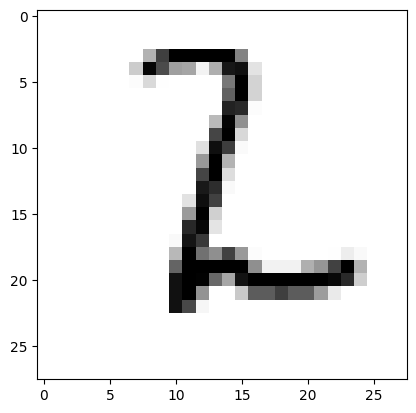

In [6]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r');

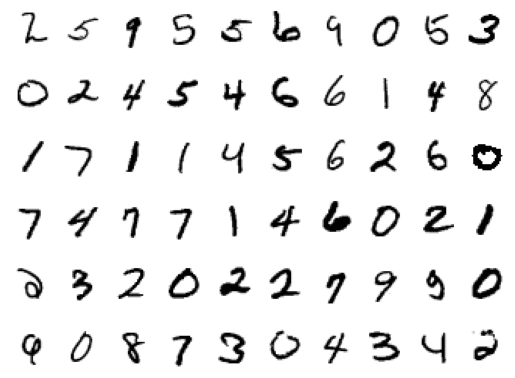

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [10]:
from torchsummary import summary
summary(model, (1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 128]              100,480
├─ReLU: 1-2                              [-1, 1, 128]              --
├─Linear: 1-3                            [-1, 1, 64]               8,256
├─ReLU: 1-4                              [-1, 1, 64]               --
├─Linear: 1-5                            [-1, 1, 10]               650
├─LogSoftmax: 1-6                        [-1, 1, 10]               --
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 128]              100,480
├─ReLU: 1-2                              [-1, 1, 128]              --
├─Linear: 1-3                            [-1, 1, 64]               8,256
├─ReLU: 1-4                              [-1, 1, 64]               --
├─Linear: 1-5                            [-1, 1, 10]               650
├─LogSoftmax: 1-6                        [-1, 1, 10]               --
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42

In [11]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [12]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
        ...,
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020]])


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 8
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6368001821135153
Epoch 1 - Training loss: 0.2787864482733232
Epoch 2 - Training loss: 0.2142591532796367
Epoch 3 - Training loss: 0.17553013579836532
Epoch 4 - Training loss: 0.1475569229167916
Epoch 5 - Training loss: 0.12819736309524285
Epoch 6 - Training loss: 0.11290524111413308
Epoch 7 - Training loss: 0.10028646864604626

Training Time (in minutes) = 0.934420637289683


Predicted Digit = 2


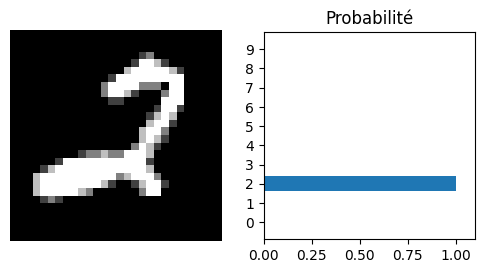

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    ''' Fonction pour afficher l'image d'entrée et le graphique des probabilités prédites '''
    ps = ps.cpu().numpy().squeeze()  # Convertir les tenseurs en numpy et retirer les dimensions inutiles
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.cpu().numpy().squeeze(), cmap='gray')  # Afficher l'image en niveaux de gris
    ax1.axis('off')

    ax2.barh(np.arange(10), ps)  # Afficher les probabilités sous forme de barres horizontales
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Probabilité')
    ax2.set_xlim(0, 1.1)

    plt.show()

# Exemple d'utilisation
images, labels = next(iter(valloader))
img = images[0].view(1, 784)

with torch.no_grad():
    logps = model(img)  # Obtenir les prédictions

ps = torch.exp(logps)  # Obtenir les probabilités en appliquant exp() sur les log-probabilités
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

# Visualiser les prédictions
view_classify(img.view(1, 28, 28), ps)


In [16]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9667


In [20]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Définir les transformations que l'image doit subir avant de passer dans le modèle
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),  # Convertir en niveaux de gris
                                transforms.Resize((28, 28)),  # Redimensionner à 28x28
                                transforms.ToTensor(),  # Convertir en tensor
                                transforms.Normalize((0.5,), (0.5,))  # Normaliser comme les données MNIST
                               ])

# Charger l'image externe
image_path = 'R.png'
img = Image.open(image_path)

# Appliquer les transformations sur l'image
img = transform(img)

# Reformater l'image pour qu'elle ait la forme correcte (1, 784) pour correspondre à ce que le modèle attend
img = img.view(1, 784)

# Faire une prédiction avec le modèle
with torch.no_grad():
    logps = model(img)

# Convertir les log-probabilités en probabilités réelles
ps = torch.exp(logps)

# Obtenir l'index de la classe avec la probabilité la plus élevée
probab = list(ps.numpy()[0])
pred_label = probab.index(max(probab))

# Afficher le résultat
print(f"Predicted Digit = {pred_label}")


Predicted Digit = 3


Epoch 1/8 - Training Loss: 0.0387, Validation Loss: 0.0739
Epoch 2/8 - Training Loss: 0.0354, Validation Loss: 0.0732
Epoch 3/8 - Training Loss: 0.0329, Validation Loss: 0.0751
Epoch 4/8 - Training Loss: 0.0308, Validation Loss: 0.0757
Epoch 5/8 - Training Loss: 0.0290, Validation Loss: 0.0706
Epoch 6/8 - Training Loss: 0.0267, Validation Loss: 0.0820
Epoch 7/8 - Training Loss: 0.0241, Validation Loss: 0.0737
Epoch 8/8 - Training Loss: 0.0234, Validation Loss: 0.0770

Training Time (in minutes) = 1.062534217039744


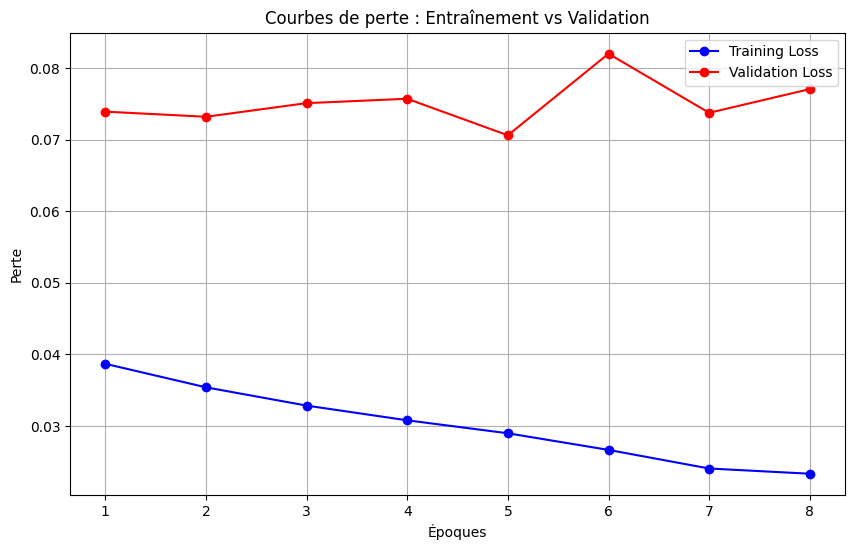

In [24]:
# Listes pour stocker les pertes d'entraînement et de validation
train_losses = []
val_losses = []

time0 = time()
epochs = 8
for e in range(epochs):
    running_loss = 0
    model.train()  # Mettre le modèle en mode entraînement
    for images, labels in trainloader:
        # Flatten MNIST images into un vecteur de longueur 784
        images = images.view(images.shape[0], -1)
        
        # Pass d'entraînement
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculer la perte moyenne d'entraînement pour cette époque
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    
    # Calculer la perte de validation
    val_loss = 0
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
    
    # Calculer la perte moyenne de validation
    val_loss = val_loss / len(valloader)
    val_losses.append(val_loss)
    
    print(f"Epoch {e+1}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("\nTraining Time (in minutes) =", (time() - time0) / 60)

# Tracer les courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss', color='b')
plt.plot(range(1, epochs + 1), val_losses, marker='o', label='Validation Loss', color='r')
plt.title('Courbes de perte : Entraînement vs Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid()
plt.show()
